In [2]:
#!/bin/python
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
import pickle
import xgboost as xgb
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, accuracy_score


from xgboost import XGBClassifier

# argument parsing 
#parser = argparse.ArgumentParser(description='Process some integers.')
#parser.add_argument('integers', metavar='N', type=int, nargs='+',
#                   help='an integer for the accumulator')
#parser.add_argument('--sum', dest='accumulate', action='store_const',
#                   const=sum, default=max,
#                   help='sum the integers (default: find the max)')

#args = parser.parse_args()
#idx_lr = sys.argv[1]
idx_lr = 1
#idx_md = sys.argv[2]
idx_md = 1

# set seed 
rng = np.random.RandomState(1)

# set directory
os.getcwd()
os.chdir("/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/data")

# list of desired DDI Types
desired_DDI = [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 26, 28, 30, 31, 32, 38, 40, 41, 43, 44, 45,
               49, 50, 51, 52, 54, 55, 62, 67, 68, 72, 74, 76, 78, 79, 80, 81]


# parameters
parameters = {"learning_rate"    : [0.01, 0.10, 0.25, 0.5, 1 ],
    "max_depth"        : [ 3, 4, 5, 6, 7],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

# load the data 
ddidata = pd.read_excel("DrugBank_known_ddi.xlsx")
interactiondict = pd.read_csv("Interaction_information.csv")
safe_drugs = pd.read_csv("safe_drug_combos.csv")
drug_similarity_feature = pd.read_csv("drug_similarity.csv")
drug_similarity = drug_similarity_feature.iloc[:, 1:len(drug_similarity_feature)+1]

# filter ddidata for desired DDI types
up_ddidata = ddidata[ddidata.Label.isin(desired_DDI)]
new_ddidata = up_ddidata.copy()

# convert types to int
new_ddidata.drug1 = up_ddidata.drug1.str[2:].astype(int)
new_ddidata.drug2 = up_ddidata.drug2.str[2:].astype(int)
new_ddidata.Label = up_ddidata.Label


# incorporate safe_drugs into new_ddidata with DDIType 0
safe_drugs["Label"] = 0

frames = [safe_drugs, new_ddidata]
ddi_df = pd.concat(frames)

# create a DB to index dictionary from similarity dataset
DB_to_index = {}
i = 0
for col in drug_similarity.columns:
    DB_to_index[int(col[2:7])] = i
    i = i + 1

# filter output to only include DBs with similarity features
ddi_df_output = ddi_df[ddi_df.drug1.isin(DB_to_index)]
ddi_output = ddi_df_output[ddi_df_output.drug2.isin(DB_to_index)]

# filter out the duplicate samples
bool_series_to_delete = ddi_output[['drug1', 'drug2']].duplicated()
ddi_clean = ddi_output[~bool_series_to_delete]


# feature building 
# add similarity feature for each drug-drug pair
n_similarity = 2159
sim_array = np.empty([ddi_clean.shape[0], 2*n_similarity], dtype='float16')
i = 0
for index, (_, row) in enumerate(ddi_clean.iterrows()):
    if index % 10000 == 0:
        print("INFO: iter " + str(index + 1))
    drug1_index = DB_to_index[row["drug1"]]
    drug2_index = DB_to_index[row["drug2"]]
    feature_vec = np.hstack([drug_similarity.iloc[:,drug1_index],drug_similarity.iloc[:,drug2_index]])
    sim_array[index, ] = feature_vec
    
# create input and output vectors for training

X_data = sim_array
y_data = np.array(ddi_clean.Label)

# transform the y
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)

#y_data = tf.keras.utils.to_categorical(encoded_Y)
y_data = encoded_Y

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_data, y_data, test_size = 0.3
                                                                           , random_state = 1)
X_test, X_val, y_test, y_val = sklearn.model_selection.train_test_split(X_test, y_test, test_size = 0.5
                                                                       , random_state = 1)

# dmatrix
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)
dval = xgb.DMatrix(X_val, label = y_val)

print("----- INFO: training data preprocess is done. -----")

INFO: iter 1
INFO: iter 10001
INFO: iter 20001
INFO: iter 30001
INFO: iter 40001
INFO: iter 50001
INFO: iter 60001
INFO: iter 70001
INFO: iter 80001
INFO: iter 90001
INFO: iter 100001
----- INFO: training data preprocess is done. -----


In [3]:
# parameters
parameters = {"learning_rate"    : [0.10, 0.25, 0.5],
    "max_depth"        : [ 3, 4, 5, 6, 7],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [4]:
# param
output_dir = "/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/code/xgboost/output_round_100/"
model_dict = {}
count = 0
for i in range(3):
    for j in range(5):
        print("INFO: " + "processing number" + str(count + 1))
        learning_rate = parameters["learning_rate"][i]
        max_depth = parameters["max_depth"][j]
        count += 1
        history_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_history_dict.pickle"
        model_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_xgb.pickle"
        history_fo = open(history_path, "rb")
        model_fo = open(model_path, "rb")
        history_dict = pickle.load(history_fo)
        bst = pickle.load(model_fo)
        # load the object from the file into var b
        model_dict[count] = {'model': bst,
                             'history': history_dict}
        history_fo.close()
        model_fo.close()

INFO: processing number1
INFO: processing number2
INFO: processing number3
INFO: processing number4
INFO: processing number5
INFO: processing number6
INFO: processing number7
INFO: processing number8
INFO: processing number9
INFO: processing number10
INFO: processing number11
INFO: processing number12
INFO: processing number13
INFO: processing number14
INFO: processing number15


In [11]:
model_dict[1]['history']['train']

{'merror': [0.230888,
  0.186444,
  0.168081,
  0.156372,
  0.14948,
  0.140992,
  0.133975,
  0.127041,
  0.121243,
  0.117559,
  0.114547,
  0.11106,
  0.107586,
  0.103776,
  0.099826,
  0.097669,
  0.094784,
  0.092291,
  0.089209,
  0.085988,
  0.083158,
  0.080525,
  0.078326,
  0.076295,
  0.074054,
  0.072387,
  0.070608,
  0.068703,
  0.06684,
  0.065075],
 'mlogloss': [1.4316,
  1.11637,
  0.938264,
  0.80793,
  0.719506,
  0.648648,
  0.58746,
  0.535616,
  0.494667,
  0.459511,
  0.43197,
  0.406748,
  0.384339,
  0.362965,
  0.343717,
  0.328915,
  0.315362,
  0.301526,
  0.289879,
  0.278335,
  0.268389,
  0.260126,
  0.252401,
  0.245388,
  0.238549,
  0.232414,
  0.226294,
  0.220372,
  0.214846,
  0.210097]}

dict_keys(['validation', 'test', 'train'])


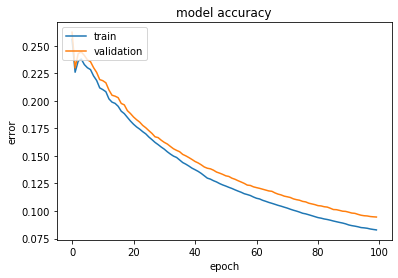

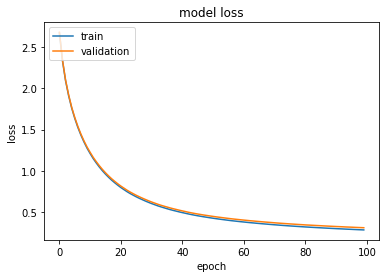

In [8]:
# list all data in history
history = model_dict[1]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['validation', 'test', 'train'])


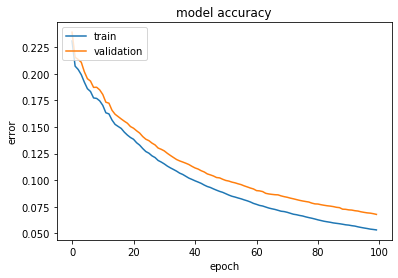

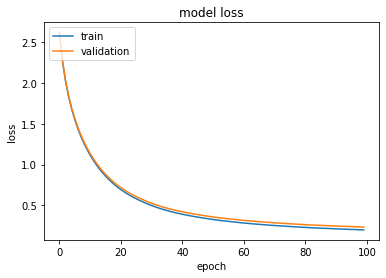

In [9]:
# list all data in history
history = model_dict[2]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['validation', 'test', 'train'])


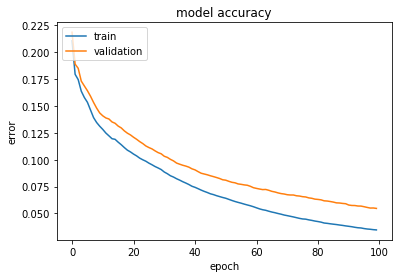

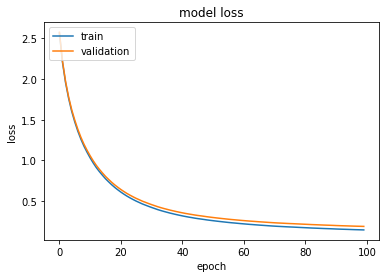

In [10]:
# list all data in history
history = model_dict[3]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['validation', 'test', 'train'])


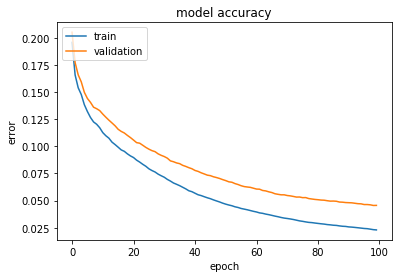

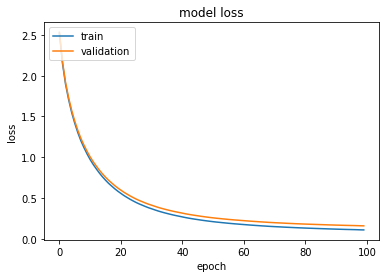

In [11]:
# list all data in history
history = model_dict[4]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['validation', 'test', 'train'])


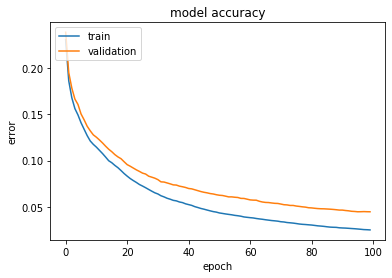

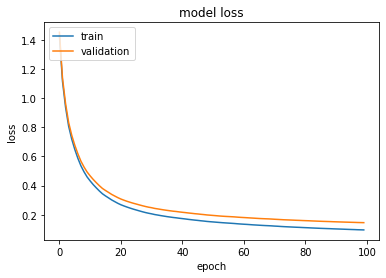

In [12]:
# list all data in history
history = model_dict[7]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['validation', 'test', 'train'])


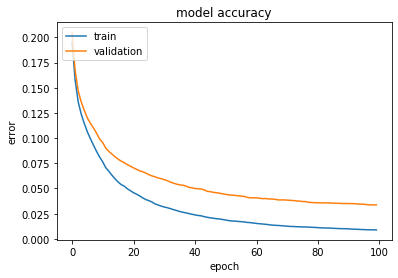

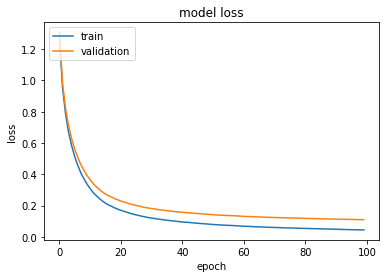

In [36]:
# list all data in history
history = model_dict[9]["history"]
print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x
plt.plot([x for x in history['train']['merror']])
plt.plot([x for x in history['validation']['merror']])
plt.title('model accuracy')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train']['mlogloss'])
plt.plot(history['validation']['mlogloss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [49]:
model_dict[16]["history"]["test"]["merror"]

[0.194653, 0.787241, 0.558991, 0.696189, 0.532322]

In [13]:
test_vec = []
val_vec = []
train_vec = []
for i in range(1, 16):
    test_vec.append(model_dict[i]["history"]["test"]["merror"][-1]) 
    val_vec.append(model_dict[i]["history"]["validation"]["merror"][-1]) 
    train_vec.append(model_dict[i]["history"]["train"]["merror"][-1]) 

In [35]:
idx = 9
print(1 - train_vec[idx])
print(1 - test_vec[idx])
print(1 - val_vec[idx])

0.995266
0.970259
0.968952


### Classification Report

In [5]:
from sklearn.metrics import classification_report 

In [7]:
bst = model_dict[9]['model']
preds = bst.predict(dtest)

In [16]:
#target_names=target_names
#desired_DDI
best_preds = np.asarray([np.argmax(line) for line in preds])

In [17]:
best_preds[:5]

array([27, 27, 27, 27, 13])

In [13]:
y_test[:5]

array([27, 27, 27, 27, 13])

In [44]:
set(range(43)) - set(y_test)

{16, 17, 30}

In [43]:
(np.unique(y_test))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42])

In [24]:
desired_DDI = [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 26, 28, 30, 31, 32, 38, 40, 41, 43, 44, 45,
               49, 50, 51, 52, 54, 55, 62, 67, 68, 72, 74, 76, 78, 79, 80, 81]
desired_DDI_updated = [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 26, 28, 30, 31, 32, 38, 40, 41, 43, 44, 45,
               49, 50, 51, 52, 54, 55, 62, 67, 68, 72, 74, 76, 78, 79, 80, 81]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 26,
 28,
 30,
 31,
 32,
 38,
 40,
 41,
 43,
 44,
 45,
 49,
 50,
 51,
 52,
 54,
 55,
 62,
 67,
 68,
 72,
 74,
 76,
 78,
 79,
 80,
 81]

In [27]:
import pprint
pp = pprint.PrettyPrinter(depth=6)

In [36]:
target_names = [ "DDI type " + str(x) for x in desired_DDI]

In [ ]:
desire

In [38]:
print(classification_report(best_preds, y_test))

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1459
           1       0.20      1.00      0.33         1
           2       0.95      1.00      0.97        52
           3       1.00      1.00      1.00        80
           4       0.98      0.97      0.98       813
           5       0.96      0.96      0.96        50
           6       0.98      0.98      0.98       500
           7       1.00      1.00      1.00         2
           8       0.96      1.00      0.98        26
           9       0.96      0.95      0.96       837
          10       0.93      1.00      0.96        13
          11       0.69      0.92      0.79        12
          12       0.94      0.94      0.94        17
          13       0.98      0.98      0.98       931
          14       0.95      1.00      0.97        57
          15       1.00      1.00      1.00        15
          18       0.91      0.91      0.91        76
          19       0.00    

In [ ]:
d

In [ ]:
print(classification_report(best_preds, y_test)), labels = target_name

In [32]:
len(desired_DDI)

43

In [ ]:
print(classification_report(best_preds, y_test))

In [31]:
print(classification_report(best_preds, y_test))
      

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1459
           1       0.20      1.00      0.33         1
           2       0.95      1.00      0.97        52
           3       1.00      1.00      1.00        80
           4       0.98      0.97      0.98       813
           5       0.96      0.96      0.96        50
           6       0.98      0.98      0.98       500
           7       1.00      1.00      1.00         2
           8       0.96      1.00      0.98        26
           9       0.96      0.95      0.96       837
          10       0.93      1.00      0.96        13
          11       0.69      0.92      0.79        12
          12       0.94      0.94      0.94        17
          13       0.98      0.98      0.98       931
          14       0.95      1.00      0.97        57
          15       1.00      1.00      1.00        15
          18       0.91      0.91      0.91        76
          19       0.00    

In [20]:
classification_report(best_preds, y_test, target_names = desired_DDI)

ValueError: Number of classes, 40, does not match size of target_names, 43. Try specifying the labels parameter

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

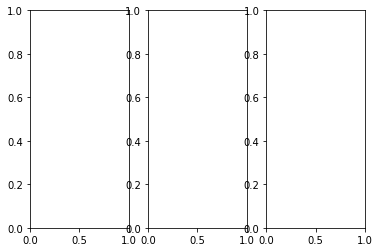

In [17]:
fig, axs = plt.subplots(1, 3)

array([0.082892, 0.053324, 0.034611, 0.023041, 0.014595, 0.041264,
       0.024848, 0.014371, 0.008894, 0.004734, 0.361823, 0.274099,
       0.289968, 0.285262, 0.31336 ])

In [28]:
data = [1 - np.array(train_vec), 1 - np.array(val_vec), 1 - np.array(test_vec)]

In [29]:
data

[array([0.917108, 0.946676, 0.965389, 0.976959, 0.985405, 0.958736,
        0.975152, 0.985629, 0.991106, 0.995266, 0.638177, 0.725901,
        0.710032, 0.714738, 0.68664 ]),
 array([0.905419, 0.932087, 0.945356, 0.954376, 0.959213, 0.942545,
        0.955487, 0.962416, 0.966207, 0.968952, 0.632525, 0.718282,
        0.704817, 0.708935, 0.670567]),
 array([0.905811, 0.932349, 0.947709, 0.957514, 0.964573, 0.94333 ,
        0.957448, 0.962808, 0.969083, 0.970259, 0.632917, 0.716844,
        0.705667, 0.708282, 0.673377])]

[Text(0, 0, 'train'), Text(0, 0, 'validation'), Text(0, 0, 'test')]

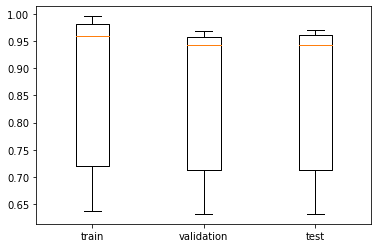

In [31]:
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(["train", "validation", "test"])

In [34]:
max(1 - np.array(test_vec))

0.970259

In [37]:
# param
output_dir = "/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/code/dnn/output_learning_rate/"
model_dict_dnn = {}
count = 0
lr_vec = [1e-05, 0.0001, 0.001, 0.01, 0.1]
for i in range(5):
    print("INFO: " + "processing number" + str(count + 1))
    learning_rate = lr_vec[i]
    max_depth = parameters["max_depth"][j]
    count += 1
    history_path = output_dir + "_lr_" + str(learning_rate) + "_history_dict.pickle"
    model_path = output_dir + "_lr_" + str(learning_rate)  + "_ann.pickle"
    history_fo = open(history_path, "rb")
    model_fo = open(model_path, "rb")
    history_dict = pickle.load(history_fo)
    bst = pickle.load(model_fo)
    # load the object from the file into var b
    model_dict_dnn[count] = {'model': bst,
                         'history': history_dict}
    history_fo.close()
    model_fo.close()

INFO: processing number1


EOFError: Ran out of input

In [16]:
model_dict[4]["history"]

{'validation': {'merror': [0.239101,
   0.195307,
   0.178574,
   0.166678,
   0.16086,
   0.150533,
   0.144192,
   0.137199,
   0.132231,
   0.127851,
   0.125302,
   0.122296,
   0.119093,
   0.115563,
   0.112295,
   0.109615,
   0.106478,
   0.103994,
   0.102033,
   0.098765,
   0.095627,
   0.093862,
   0.091901,
   0.089941,
   0.088241,
   0.086411,
   0.08543,
   0.083077,
   0.082032,
   0.08092],
  'mlogloss': [1.45318,
   1.138941,
   0.963364,
   0.833054,
   0.746361,
   0.677328,
   0.618566,
   0.56745,
   0.52776,
   0.493525,
   0.466553,
   0.442212,
   0.420036,
   0.399189,
   0.380351,
   0.366194,
   0.353042,
   0.339456,
   0.328317,
   0.317332,
   0.307659,
   0.299666,
   0.292075,
   0.285407,
   0.278978,
   0.27329,
   0.267427,
   0.261768,
   0.256468,
   0.251766]},
 'test': {'merror': [0.234852,
   0.194588,
   0.176351,
   0.165436,
   0.159422,
   0.150794,
   0.144389,
   0.138702,
   0.134126,
   0.128701,
   0.125368,
   0.121773,
   0.118504,
 

In [17]:
model_dict[3]["history"]

{'validation': {'merror': [0.239101,
   0.195307,
   0.178574,
   0.166678,
   0.16086,
   0.150533,
   0.144192,
   0.137199,
   0.132231,
   0.127851,
   0.125302,
   0.122296,
   0.119093,
   0.115563,
   0.112295,
   0.109615,
   0.106478,
   0.103994,
   0.102033,
   0.098765,
   0.095627,
   0.093862,
   0.091901,
   0.089941,
   0.088241,
   0.086411,
   0.08543,
   0.083077,
   0.082032,
   0.08092],
  'mlogloss': [1.45318,
   1.138941,
   0.963364,
   0.833054,
   0.746361,
   0.677328,
   0.618566,
   0.56745,
   0.52776,
   0.493525,
   0.466553,
   0.442212,
   0.420036,
   0.399189,
   0.380351,
   0.366194,
   0.353042,
   0.339456,
   0.328317,
   0.317332,
   0.307659,
   0.299666,
   0.292075,
   0.285407,
   0.278978,
   0.27329,
   0.267427,
   0.261768,
   0.256468,
   0.251766]},
 'test': {'merror': [0.234852,
   0.194588,
   0.176351,
   0.165436,
   0.159422,
   0.150794,
   0.144389,
   0.138702,
   0.134126,
   0.128701,
   0.125368,
   0.121773,
   0.118504,
 

In [5]:
# param
import pickle

# parameters
parameters = {"learning_rate"    : [0.01, 0.10, 0.25, 0.5, 1 ],
    "max_depth"        : [ 3, 4, 5, 6, 7],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }


output_dir = "/ysm-gpfs/pi/zhao/zy92/projects/ddipred/ddi_pred/code/xgboost/output_round_100_cv//"
model_dict = {}
count = 0
for i in range(4):
    for j in range(5):
        print("INFO: " + "processing number" + str(count + 1))
        learning_rate = parameters["learning_rate"][i]
        max_depth = parameters["max_depth"][j]
        count += 1
        history_path = output_dir + "_lr_" + str(learning_rate) + "_md_" + str(max_depth) + "_history_dict.pickle"
        history_fo = open(history_path, "rb")
        history_dict = pickle.load(history_fo)
        # load the object from the file into var b
        model_dict[count] = {'history': history_dict}
        history_fo.close()


INFO: processing number1
INFO: processing number2
INFO: processing number3
INFO: processing number4
INFO: processing number5
INFO: processing number6
INFO: processing number7
INFO: processing number8
INFO: processing number9
INFO: processing number10
INFO: processing number11
INFO: processing number12
INFO: processing number13
INFO: processing number14
INFO: processing number15
INFO: processing number16
INFO: processing number17
INFO: processing number18
INFO: processing number19
INFO: processing number20


In [10]:
type(model_dict[1]['history'])

pandas.core.frame.DataFrame

In [11]:
model_dict[1]['history']

,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.269404,0.000861,2.276231,0.000072,0.272303,0.004764,2.276363,0.000160
1,0.263839,0.007530,2.250921,0.000161,0.266920,0.010930,2.251178,0.000299
2,0.260705,0.006817,2.226395,0.000245,0.263414,0.010489,2.226695,0.000408
3,0.237426,0.011859,2.202420,0.000129,0.239494,0.017605,2.202832,0.000576
4,0.220650,0.003884,2.179154,0.000210,0.223017,0.007136,2.179683,0.000620
5,0.216640,0.005031,2.156608,0.000229,0.219620,0.007409,2.157266,0.000592
6,0.209024,0.004508,2.134818,0.000256,0.211201,0.004403,2.135575,0.000605
7,0.205456,0.003115,2.113351,0.000255,0.208130,0.004026,2.114274,0.000648
8,0.202701,0.001435,2.092741,0.000380,0.205926,0.005630,2.093777,0.000790
9,0.200650,0.001287,2.072505,0.000313,0.204625,0.004607,2.073702,0.000838


In [14]:
model_dict[i]['history']['test-merror-mean']

0     0.106124
1     0.060199
2     0.046829
3     0.037543
4     0.031075
5     0.026486
6     0.024101
7     0.021066
8     0.019115
9     0.017236
10    0.015971
11    0.014056
12    0.013369
13    0.012466
14    0.011563
15    0.011129
16    0.010334
17    0.010334
18    0.009900
19    0.009611
20    0.009358
21    0.009142
22    0.008853
23    0.008708
24    0.008564
25    0.008672
26    0.008419
27    0.008238
28    0.008202
29    0.008130
30    0.007877
31    0.007877
32    0.007877
33    0.007696
34    0.007769
35    0.007841
36    0.007733
37    0.007769
38    0.007841
39    0.007805
40    0.007696
41    0.007588
42    0.007624
43    0.007552
44    0.007552
45    0.007588
46    0.007552
47    0.007588
48    0.007516
49    0.007516
Name: test-merror-mean, dtype: float64

In [15]:
test_merror = []
for i in range(1, 21):
    test_merror.append(model_dict[i]['history']['test-merror-mean'][49])

In [16]:
test_merror

[0.14467919999999998,
 0.1060884,
 0.0808672,
 0.060235,
 0.045384,
 0.041083800000000004,
 0.0266304,
 0.0203796,
 0.017019199999999998,
 0.014887000000000001,
 0.019512400000000003,
 0.0132608,
 0.00972,
 0.008635799999999999,
 0.0076603999999999995,
 0.0110566,
 0.0089972,
 0.0073712,
 0.007587999999999999,
 0.0075156]

In [17]:
min(test_merror)

0.0073712

In [27]:
1- np.mean(test_merror)

0.9682884285714286

In [20]:
model_dict[18]['history']['train-merror-mean']

0     0.168690
1     0.072719
2     0.054698
3     0.043360
4     0.035221
5     0.028491
6     0.023433
7     0.019205
8     0.015827
9     0.013126
10    0.011192
11    0.009494
12    0.007967
13    0.006730
14    0.005872
15    0.005014
16    0.004490
17    0.003704
18    0.003324
19    0.002954
20    0.002529
21    0.002105
22    0.001807
23    0.001527
24    0.001346
25    0.001111
26    0.000994
27    0.000759
28    0.000660
29    0.000515
30    0.000397
31    0.000352
32    0.000307
33    0.000280
34    0.000217
35    0.000217
36    0.000181
37    0.000136
38    0.000118
39    0.000099
40    0.000099
41    0.000072
42    0.000072
43    0.000054
44    0.000054
45    0.000063
46    0.000045
47    0.000045
48    0.000045
49    0.000045
Name: train-merror-mean, dtype: float64

In [19]:
model_dict[18]['history']['test-merror-mean']

0     0.175935
1     0.082674
2     0.064137
3     0.052611
4     0.045059
5     0.039675
6     0.034471
7     0.029305
8     0.027136
9     0.024427
10    0.022331
11    0.020343
12    0.017922
13    0.016549
14    0.015610
15    0.014778
16    0.014056
17    0.013514
18    0.012683
19    0.012249
20    0.011635
21    0.011021
22    0.010370
23    0.010370
24    0.009865
25    0.009612
26    0.009142
27    0.009142
28    0.008852
29    0.008961
30    0.008455
31    0.008419
32    0.008347
33    0.008238
34    0.008383
35    0.008202
36    0.008058
37    0.008058
38    0.007986
39    0.007985
40    0.007877
41    0.007877
42    0.007624
43    0.007624
44    0.007516
45    0.007552
46    0.007552
47    0.007660
48    0.007443
49    0.007371
Name: test-merror-mean, dtype: float64

In [21]:
#!/bin/python
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
import pickle
import xgboost as xgb
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, accuracy_score


from xgboost import XGBClassifier

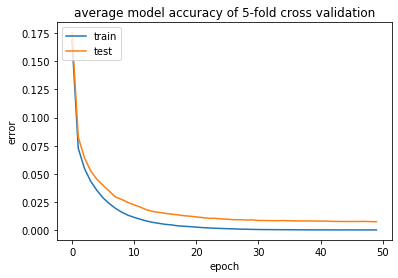

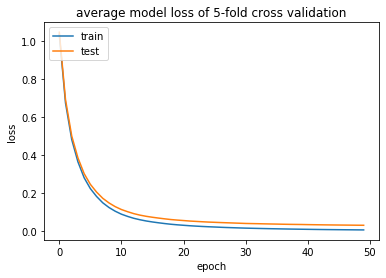

In [23]:
# list all data in history
#history = model_dict[9]["history"]
#print(history.keys())
# summarize history for accuracy
#convert_func = lambda x: 1-x

#model_dict[18]['history']['train-merror-mean']
#model_dict[18]['history']['test-merror-mean']

plt.plot([x for x in model_dict[18]['history']['train-merror-mean']])
plt.plot([x for x in model_dict[18]['history']['test-merror-mean']])
plt.title('average model accuracy of 5-fold cross validation')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_dict[18]['history']['train-mlogloss-mean'])
plt.plot(model_dict[18]['history']['test-mlogloss-mean'])
plt.title('average model loss of 5-fold cross validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
mean()

In [24]:
model_dict[18]['history']

,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.168690,0.001514,1.033071,0.009103,0.175935,0.009465,1.044413,0.016052
1,0.072719,0.002958,0.672479,0.011274,0.082674,0.005331,0.690495,0.017175
2,0.054698,0.002285,0.480424,0.008407,0.064137,0.003366,0.499466,0.011682
3,0.043360,0.000861,0.363042,0.006240,0.052611,0.003854,0.384032,0.010142
4,0.035221,0.000590,0.279458,0.002532,0.045059,0.003229,0.301086,0.007891
5,0.028491,0.001434,0.222359,0.004017,0.039675,0.003556,0.244788,0.006224
6,0.023433,0.001261,0.181031,0.003395,0.034471,0.003580,0.204201,0.005442
7,0.019205,0.000990,0.147680,0.002352,0.029305,0.002142,0.171362,0.003889
8,0.015827,0.000584,0.122982,0.002265,0.027136,0.002816,0.147068,0.004943
9,0.013126,0.000450,0.103456,0.001962,0.024427,0.002020,0.127534,0.004625
